# HW 4: MLE/MAP

## Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)
Consider the theory and the notation provided in the the MLE/MAP section (https://devangelista2.github.io/statistical-mathematical-methods/regression_classification/MLE_MAP.html). Let $f_\theta(x)$ be a polynomial regression model as in the previous Homework, and let the `poly_regression_small.csv` from Virtuale be the training set. Then, sample 20% of the data in the `poly_regression_large.csv` dataset to use as test set.

* For a given value of $K$, write three Python functions computing $\theta_{MLE}$, i.e. the optimal parameters obtained by optimizing the MLE-related loss function with Gaussian assumption on the likelihood $p_\theta(y | x)$, by Gradient Descent, Stochastic Gradient Descent (with a `batch_size` = 5), and Normal Equations method with Cholesky Decomposition.
* Compare the performance of the three regression model computed above. In particular, if $(X_{test}, Y_{test})$ is the test set from the `poly_regression_large.csv` dataset, for each of the model, compute:

  $$
  Err = \frac{1}{N_{test}} \sum_{i=1}^{N_{test}} (f_\theta(x^i) - y^i)^2,
  $$

  where $N_{test}$ is the number of elements in the test set, $(x^i, y^i)$ are the input and output elements in the test set. Comment the performance of the three models. 
* For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model $f_\theta(x)$. Comment the results.
* For increasing values of $K$, compute the training and test error as discussed above. Plot the two errors with respect to $K$. Comment the results.
* Repeat the same experiments by considering the MAP formulation with Gaussian assumption on the prior term $p(\theta)$. Set $K = 8$ and test different values of $\lambda > 0$ in the experiments. Comment the results, comparing:
  - the three optimization method used to obtain $\theta_{MAP}$ (i.e. GD, SGD and Normal Equations),
  - the different values of $\lambda > 0$ tested,
  - the results obtained by $\theta_{MLE}$ vs $\theta_{MAP}$.

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [90]:
# Load small dataset for training
train_data = pd.read_csv('poly_regression_small.csv')
X_train = train_data['x'].values.reshape(-1, 1)
Y_train = train_data['y'].values

# Load large dataset for testing
large_data = pd.read_csv('poly_regression_large.csv')
X_large = large_data['x'].values.reshape(-1, 1)
Y_large = large_data['y'].values

# Split large dataset
X_test, _, Y_test, _ = train_test_split(X_large, Y_large, test_size=0.2, random_state=42)

# Load data
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape) 


(50, 1) (50,) (800, 1) (800,)


In [91]:

def polynomial_features(X, K):
    poly = PolynomialFeatures(degree=K)
    return poly.fit_transform(X)


In [92]:

def gradient_descent(X, Y, grad_f, learning_rate=0.01, max_iter=10000, **kwargs):
    """
    Gradient Descent for parameter estimation
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
        learning_rate (float): Learning rate
        max_iter (int): Maximum iterations
    
    Returns:
        np.ndarray: Estimated parameters
    """
    theta = np.zeros(X.shape[1])
    for _ in range(max_iter):
        gradient = grad_f(X, Y, theta, **kwargs)
        theta -= learning_rate * gradient
    return theta

def stochastic_gradient_descent(X, Y, grad_f, batch_size=5, learning_rate=0.01, max_iter=10000 , **kwargs):
    """
    Stochastic Gradient Descent for parameter estimation
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
        batch_size (int): Mini-batch size
        learning_rate (float): Learning rate
        max_iter (int): Maximum iterations
    
    Returns:
        np.ndarray: Estimated parameters
    """
    theta = np.zeros(X.shape[1])
    n_samples = len(Y)
    
    for _ in range(max_iter):
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X[indices]
        Y_batch = Y[indices]

        gradient = grad_f(X_batch, Y_batch, theta, **kwargs)
        theta -= learning_rate * gradient
    
    return theta


In [93]:
def normal_equations(X, Y):
    """
    Normal Equations with Cholesky Decomposition
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
    
    Returns:
        np.ndarray: Estimated parameters
    """
    return np.linalg.solve(X.T @ X, X.T @ Y)

In [94]:


def map_gradient(X, Y, theta, lam):
    """
    MAP gradient computation with L2 regularization
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
        theta (np.ndarray): Current parameter estimates
        lam (float): Regularization strength
    
    Returns:
        np.ndarray: Gradient for MAP
    """
    Y_pred = X @ theta
    return 2 * X.T @ (Y_pred - Y) / len(Y) + 2 * lam * theta

In [95]:
def compute_error(X, Y, theta):
    """
    Compute Mean Squared Error
    
    Args:
        X (np.ndarray): Input features
        Y (np.ndarray): Target values
        theta (np.ndarray): Model parameters
    
    Returns:
        float: Mean Squared Error
    """
    Y_pred = X @ theta
    return np.mean((Y_pred - Y)**2)

In [96]:
def plot_regression(X_train, Y_train, X_test, Y_test, thetas, K, labels):
    """
    Plot regression models
    
    Args:
        X_train (np.ndarray): Training input
        Y_train (np.ndarray): Training output
        X_test (np.ndarray): Test input
        Y_test (np.ndarray): Test output
        thetas (list): Estimated parameters for each method
        K (int): Polynomial degree
        labels (list): Method labels
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='orange', label='Train Data', alpha=1)
    plt.scatter(X_test, Y_test, color='rebeccapurple', label='Test Data', alpha=0.5)

    x_line = np.linspace(min(X_train.min(), X_test.min()), # Provo a plottare in base a minimo e massimo per centrare il grafico
                         max(X_train.max(), X_test.max()), 100).reshape(-1, 1)
    poly_x_line = polynomial_features(x_line, K)

    for theta, label in zip(thetas, labels):
        y_line = poly_x_line @ theta
        plt.plot(x_line, y_line, label=label)

    plt.title(f'Polynomial Regression (K = {K})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [97]:
def mle_gradient(X, Y, theta):
    """
    MLE gradient computation
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
        theta (np.ndarray): Current parameter estimates
    
    Returns:
        np.ndarray: Gradient for MLE
    """
    Y_pred = X @ theta
    return 2 * X.T @ (Y_pred - Y) / len(Y)

Degree = 1:
  GD   - Train Error: 0.0389, Test Error: 0.0291
  SGD  - Train Error: 0.0390, Test Error: 0.0294
  NE   - Train Error: 0.0389, Test Error: 0.0291


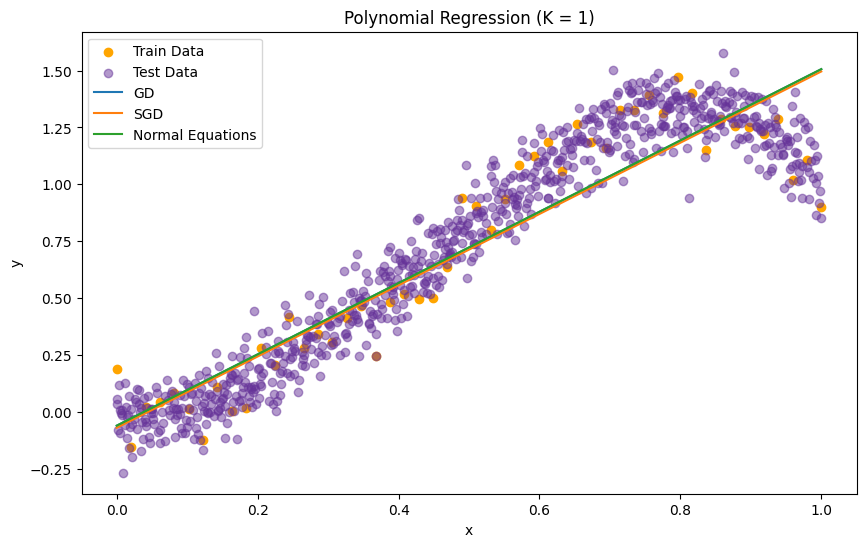

Degree = 2:
  GD   - Train Error: 0.0375, Test Error: 0.0282
  SGD  - Train Error: 0.0377, Test Error: 0.0286
  NE   - Train Error: 0.0302, Test Error: 0.0212


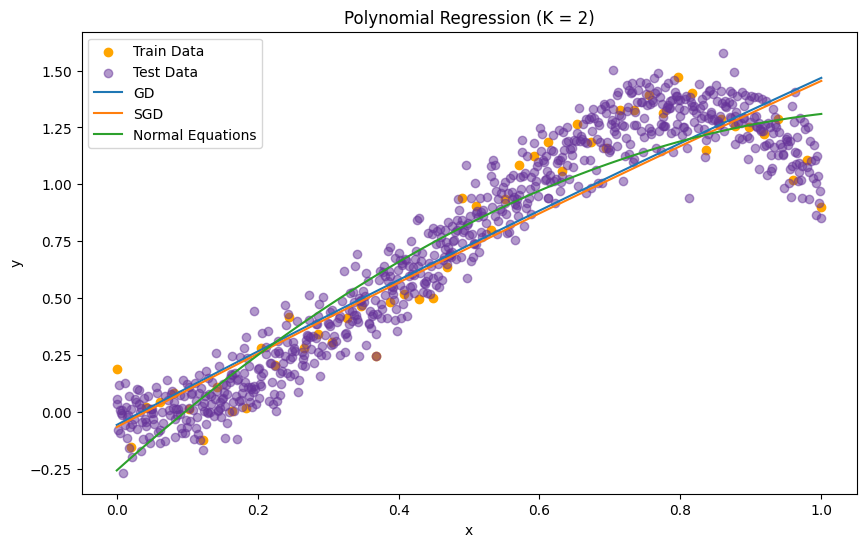

Degree = 3:
  GD   - Train Error: 0.0264, Test Error: 0.0190
  SGD  - Train Error: 0.0264, Test Error: 0.0189
  NE   - Train Error: 0.0097, Test Error: 0.0103


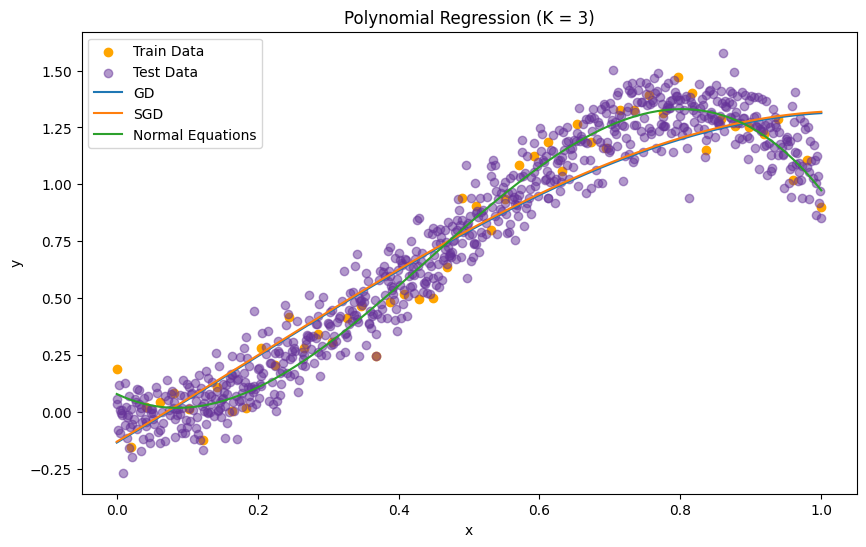

Degree = 4:
  GD   - Train Error: 0.0189, Test Error: 0.0136
  SGD  - Train Error: 0.0190, Test Error: 0.0139
  NE   - Train Error: 0.0094, Test Error: 0.0100


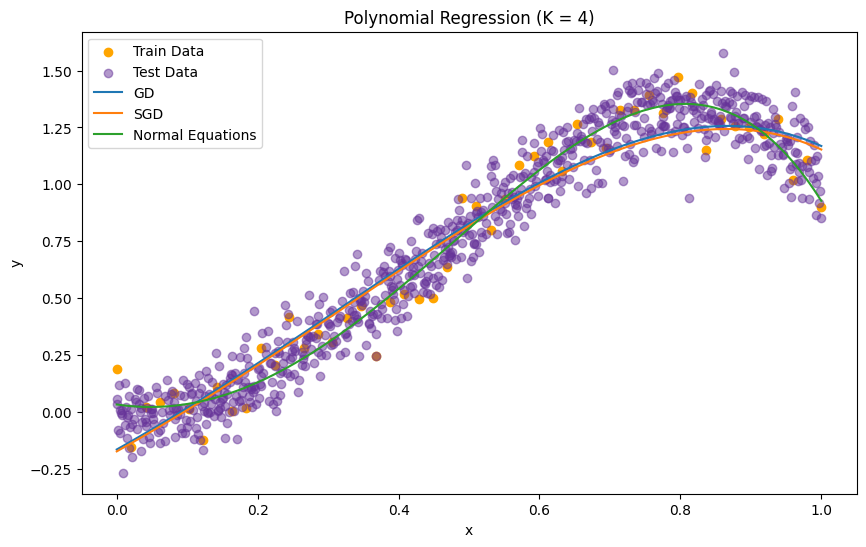

Degree = 5:
  GD   - Train Error: 0.0146, Test Error: 0.0111
  SGD  - Train Error: 0.0146, Test Error: 0.0111
  NE   - Train Error: 0.0093, Test Error: 0.0101


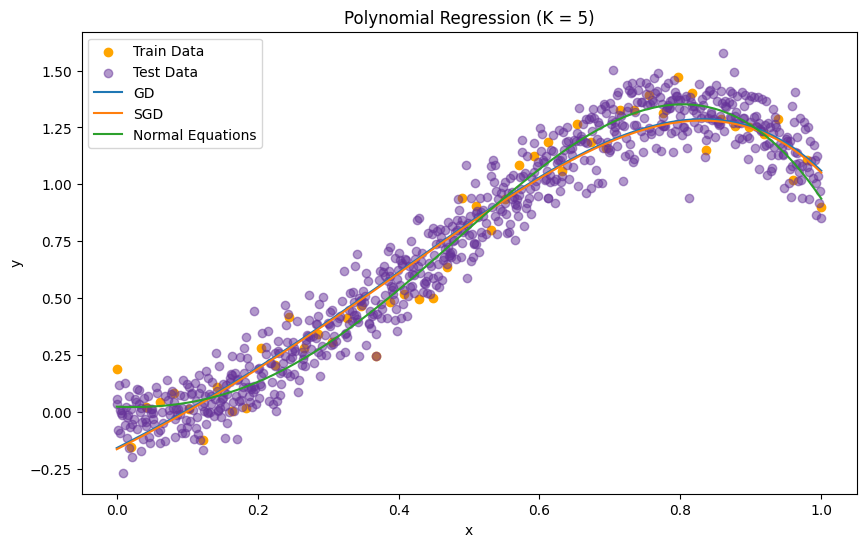

Degree = 6:
  GD   - Train Error: 0.0124, Test Error: 0.0100
  SGD  - Train Error: 0.0126, Test Error: 0.0102
  NE   - Train Error: 0.0089, Test Error: 0.0103


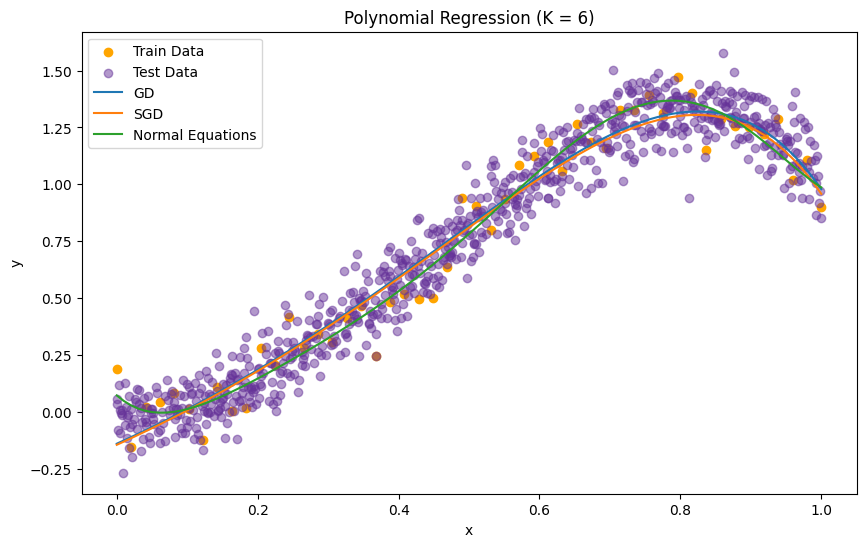

Degree = 7:
  GD   - Train Error: 0.0116, Test Error: 0.0098
  SGD  - Train Error: 0.0116, Test Error: 0.0099
  NE   - Train Error: 0.0081, Test Error: 0.0108


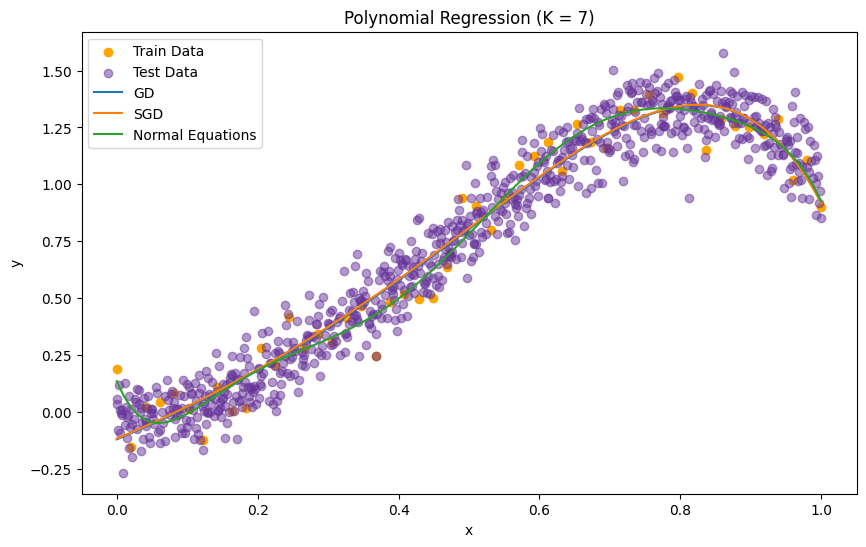

Degree = 8:
  GD   - Train Error: 0.0115, Test Error: 0.0101
  SGD  - Train Error: 0.0115, Test Error: 0.0101
  NE   - Train Error: 0.0081, Test Error: 0.0108


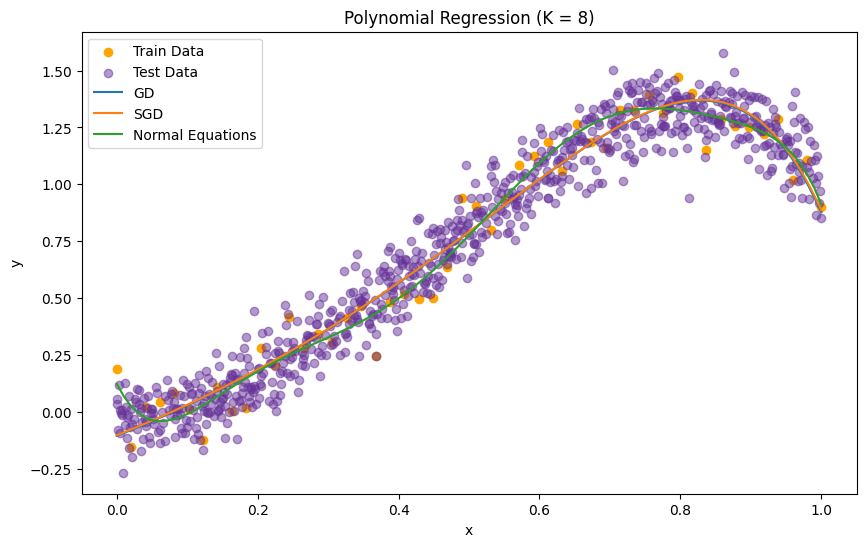

In [98]:
# Experiment with different polynomial degrees
max_K = 8
train_errors = []
test_errors = []

for K in range(1, max_K + 1):
    # Polynomial feature transformation
    X_train_poly = polynomial_features(X_train, K)
    X_test_poly = polynomial_features(X_test, K)

    # Estimation methods
    theta_gd = gradient_descent(X_train_poly, Y_train, mle_gradient)
    theta_sgd = stochastic_gradient_descent(X_train_poly, Y_train, mle_gradient)
    theta_ne = normal_equations(X_train_poly, Y_train)

    # Compute errors
    gd_train_error = compute_error(X_train_poly, Y_train, theta_gd)
    sgd_train_error = compute_error(X_train_poly, Y_train, theta_sgd)
    ne_train_error = compute_error(X_train_poly, Y_train, theta_ne)

    gd_test_error = compute_error(X_test_poly, Y_test, theta_gd)
    sgd_test_error = compute_error(X_test_poly, Y_test, theta_sgd)
    ne_test_error = compute_error(X_test_poly, Y_test, theta_ne)

    print(f"Degree = {K}:")
    print(f"  GD   - Train Error: {gd_train_error:.4f}, Test Error: {gd_test_error:.4f}")
    print(f"  SGD  - Train Error: {sgd_train_error:.4f}, Test Error: {sgd_test_error:.4f}")
    print(f"  NE   - Train Error: {ne_train_error:.4f}, Test Error: {ne_test_error:.4f}")

    # Visualization
    plot_regression(X_train, Y_train, X_test, Y_test, 
                    [theta_gd, theta_sgd, theta_ne], 
                    K, ['GD', 'SGD', 'Normal Equations'])

    # Store errors for plotting
    train_errors.append([gd_train_error, sgd_train_error, ne_train_error])
    test_errors.append([gd_test_error, sgd_test_error, ne_test_error])


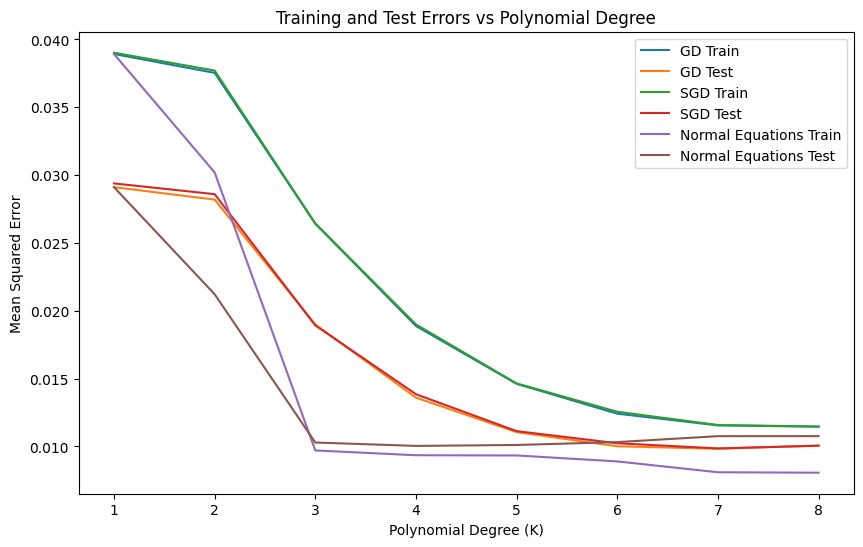

In [99]:
# Error vs K plot
plt.figure(figsize=(10, 6))
methods = ['GD', 'SGD', 'Normal Equations']
for i in range(3):
    plt.plot(range(1, max_K + 1), [errors[i] for errors in train_errors], label=f'{methods[i]} Train')
    plt.plot(range(1, max_K + 1), [errors[i] for errors in test_errors], label=f'{methods[i]} Test')

plt.title('Training and Test Errors vs Polynomial Degree')
plt.xlabel('Polynomial Degree (K)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Degree = 1:
  GD   - Train Error: 0.0900, Test Error: 0.0857
  SGD  - Train Error: 0.0900, Test Error: 0.0857
  NE   - Train Error: 0.0389, Test Error: 0.0291


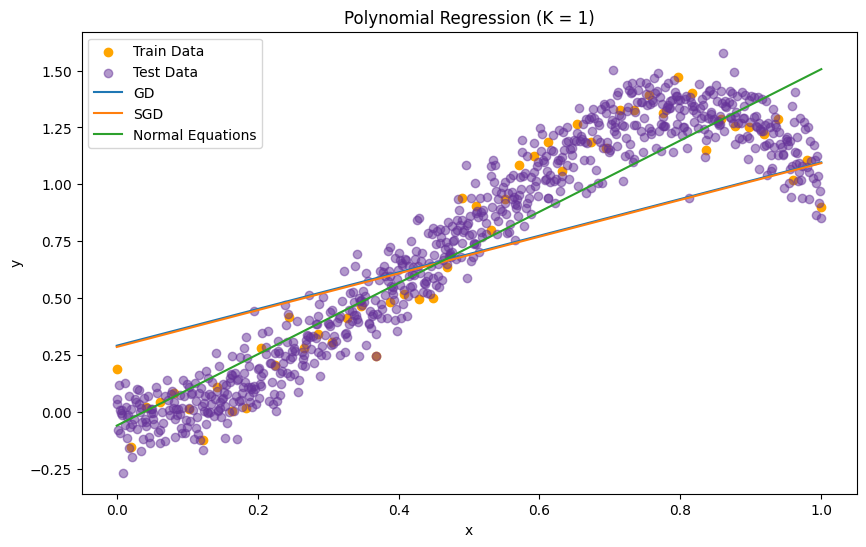

Degree = 2:
  GD   - Train Error: 0.0718, Test Error: 0.0659
  SGD  - Train Error: 0.0717, Test Error: 0.0657
  NE   - Train Error: 0.0302, Test Error: 0.0212


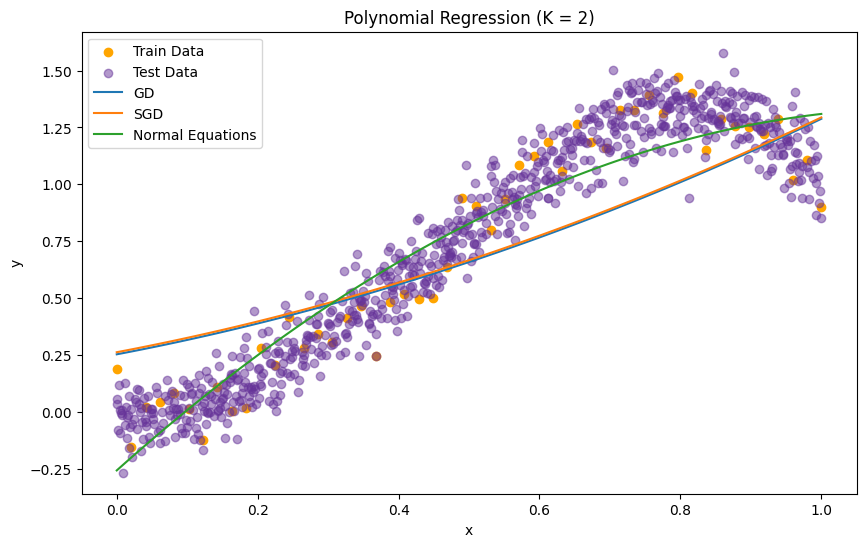

Degree = 3:
  GD   - Train Error: 0.0728, Test Error: 0.0659
  SGD  - Train Error: 0.0713, Test Error: 0.0639
  NE   - Train Error: 0.0097, Test Error: 0.0103


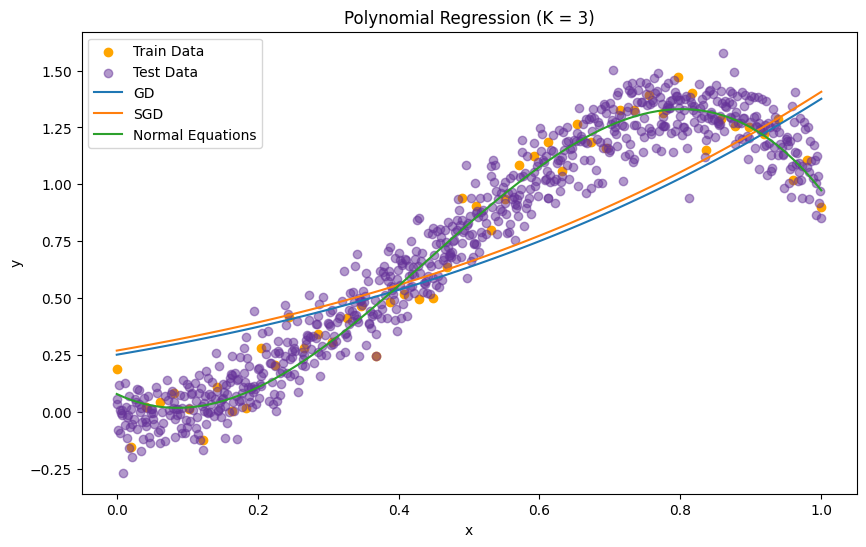

Degree = 4:
  GD   - Train Error: 0.0749, Test Error: 0.0674
  SGD  - Train Error: 0.0738, Test Error: 0.0661
  NE   - Train Error: 0.0094, Test Error: 0.0100


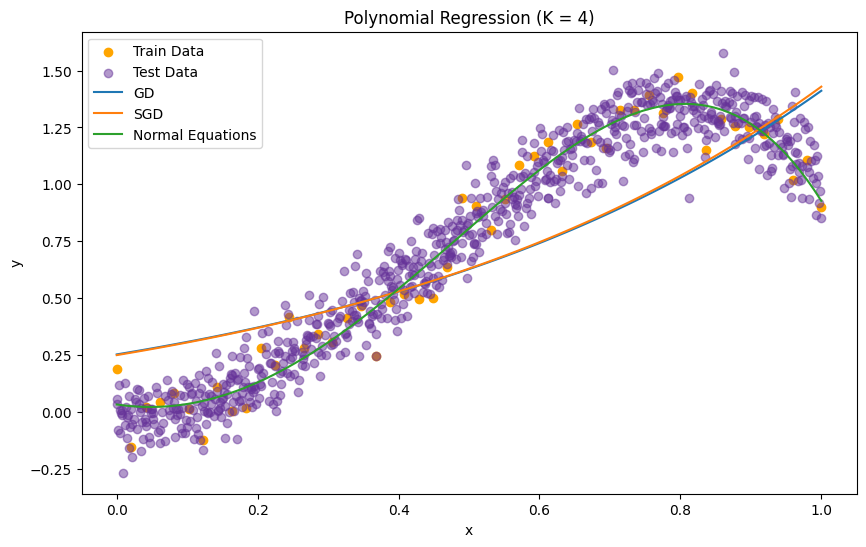

Degree = 5:
  GD   - Train Error: 0.0753, Test Error: 0.0678
  SGD  - Train Error: 0.0754, Test Error: 0.0678
  NE   - Train Error: 0.0093, Test Error: 0.0101


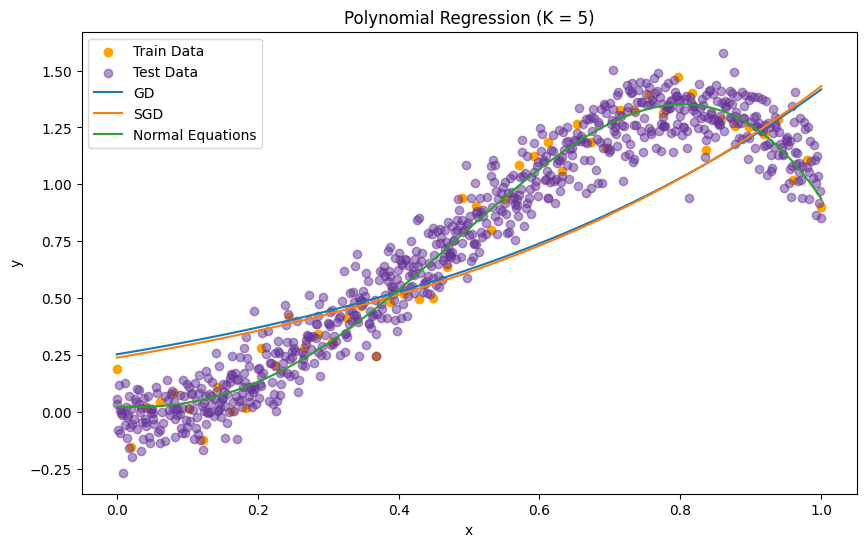

Degree = 6:
  GD   - Train Error: 0.0744, Test Error: 0.0671
  SGD  - Train Error: 0.0762, Test Error: 0.0694
  NE   - Train Error: 0.0089, Test Error: 0.0103


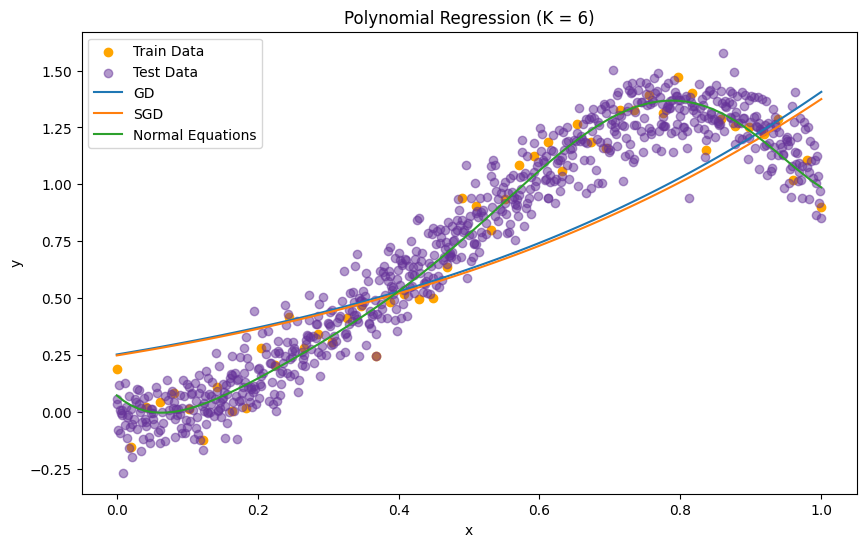

Degree = 7:
  GD   - Train Error: 0.0727, Test Error: 0.0657
  SGD  - Train Error: 0.0744, Test Error: 0.0677
  NE   - Train Error: 0.0081, Test Error: 0.0108


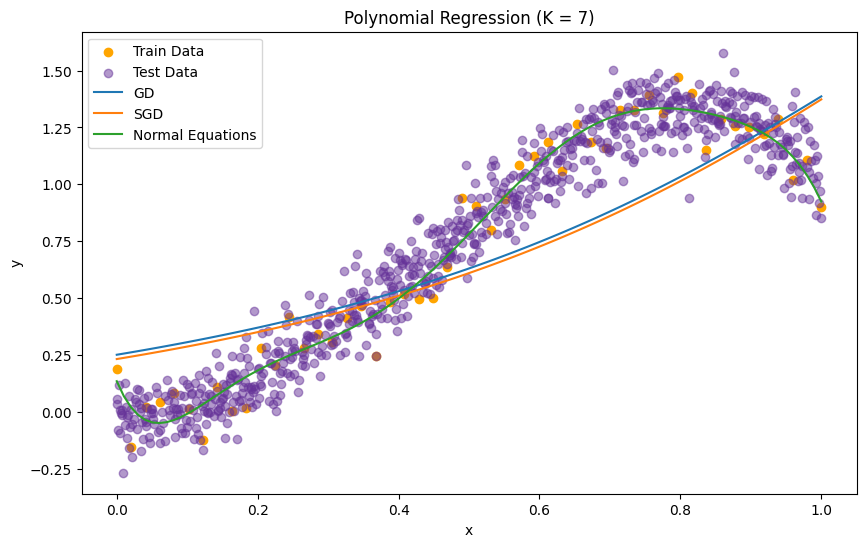

Degree = 8:
  GD   - Train Error: 0.0707, Test Error: 0.0640
  SGD  - Train Error: 0.0708, Test Error: 0.0644
  NE   - Train Error: 0.0081, Test Error: 0.0108


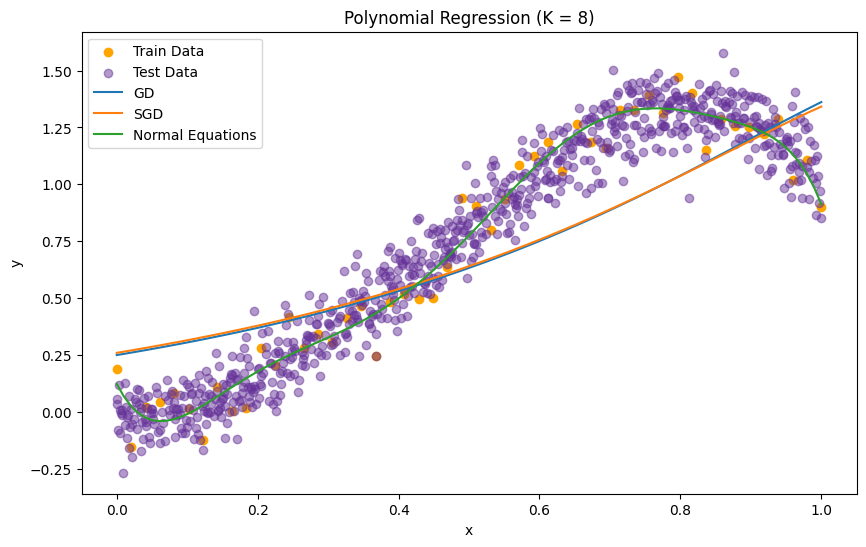

In [100]:
# Experiment with different polynomial degrees
max_K = 8
train_errors = []
test_errors = []

for K in range(1, max_K + 1):
    # Polynomial feature transformation
    X_train_poly = polynomial_features(X_train, K)
    X_test_poly = polynomial_features(X_test, K)

    # Estimation methods
    theta_gd = gradient_descent(X_train_poly, Y_train, map_gradient, lam=0.1)
    theta_sgd = stochastic_gradient_descent(X_train_poly, Y_train, map_gradient, lam=0.1)
    theta_ne = normal_equations(X_train_poly, Y_train)

    # Compute errors
    gd_train_error = compute_error(X_train_poly, Y_train, theta_gd)
    sgd_train_error = compute_error(X_train_poly, Y_train, theta_sgd)
    ne_train_error = compute_error(X_train_poly, Y_train, theta_ne)

    gd_test_error = compute_error(X_test_poly, Y_test, theta_gd)
    sgd_test_error = compute_error(X_test_poly, Y_test, theta_sgd)
    ne_test_error = compute_error(X_test_poly, Y_test, theta_ne)

    print(f"Degree = {K}:")
    print(f"  GD   - Train Error: {gd_train_error:.4f}, Test Error: {gd_test_error:.4f}")
    print(f"  SGD  - Train Error: {sgd_train_error:.4f}, Test Error: {sgd_test_error:.4f}")
    print(f"  NE   - Train Error: {ne_train_error:.4f}, Test Error: {ne_test_error:.4f}")

    # Visualization
    plot_regression(X_train, Y_train, X_test, Y_test, 
                    [theta_gd, theta_sgd, theta_ne], 
                    K, ['GD', 'SGD', 'Normal Equations'])

    # Store errors for plotting
    train_errors.append([gd_train_error, sgd_train_error, ne_train_error])
    test_errors.append([gd_test_error, sgd_test_error, ne_test_error])


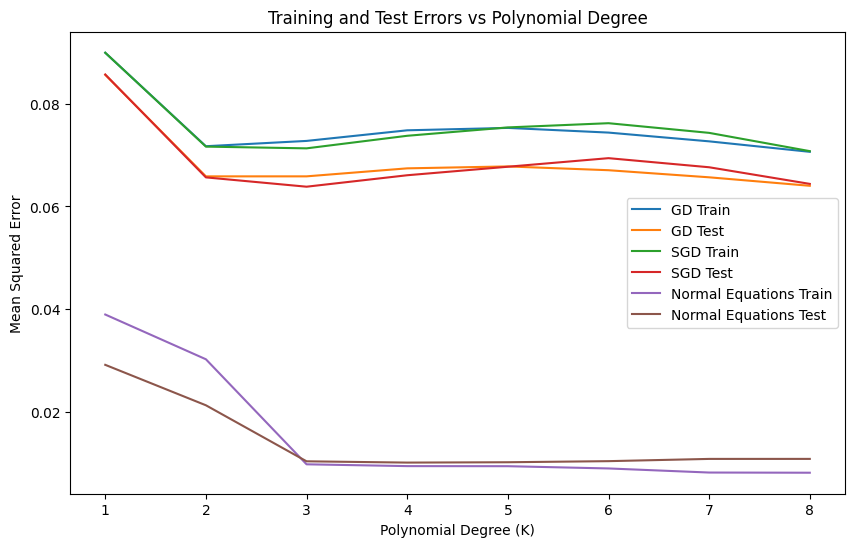

In [101]:

# Error vs K plot
plt.figure(figsize=(10, 6))
methods = ['GD', 'SGD', 'Normal Equations']
for i in range(3):
    plt.plot(range(1, max_K + 1), [errors[i] for errors in train_errors], label=f'{methods[i]} Train')
    plt.plot(range(1, max_K + 1), [errors[i] for errors in test_errors], label=f'{methods[i]} Test')

plt.title('Training and Test Errors vs Polynomial Degree')
plt.xlabel('Polynomial Degree (K)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


MAP Performance:
λ = 0.1:
  GD   - Train Error: 0.0707, Test Error: 0.0640
  SGD  - Train Error: 0.0703, Test Error: 0.0633
  NE   - Train Error: 0.0081, Test Error: 0.0108


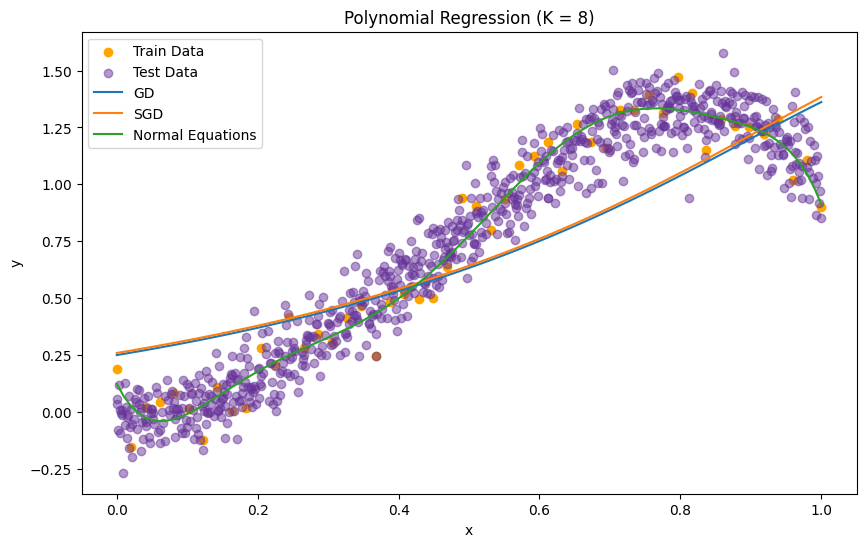

λ = 1:
  GD   - Train Error: 0.0707, Test Error: 0.0640
  SGD  - Train Error: 0.0702, Test Error: 0.0632
  NE   - Train Error: 0.0081, Test Error: 0.0108


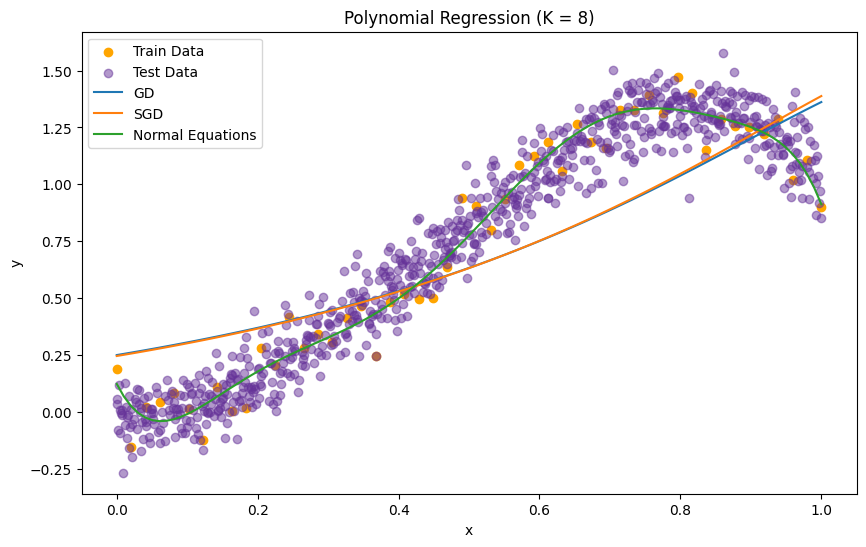

λ = 10:
  GD   - Train Error: 0.0707, Test Error: 0.0640
  SGD  - Train Error: 0.0715, Test Error: 0.0647
  NE   - Train Error: 0.0081, Test Error: 0.0108


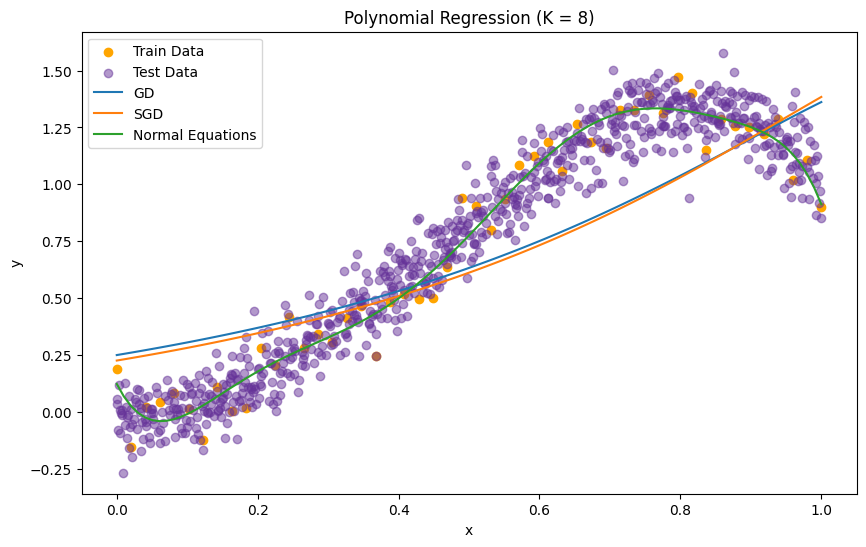

λ = 100:
  GD   - Train Error: 0.0707, Test Error: 0.0640
  SGD  - Train Error: 0.0704, Test Error: 0.0636
  NE   - Train Error: 0.0081, Test Error: 0.0108


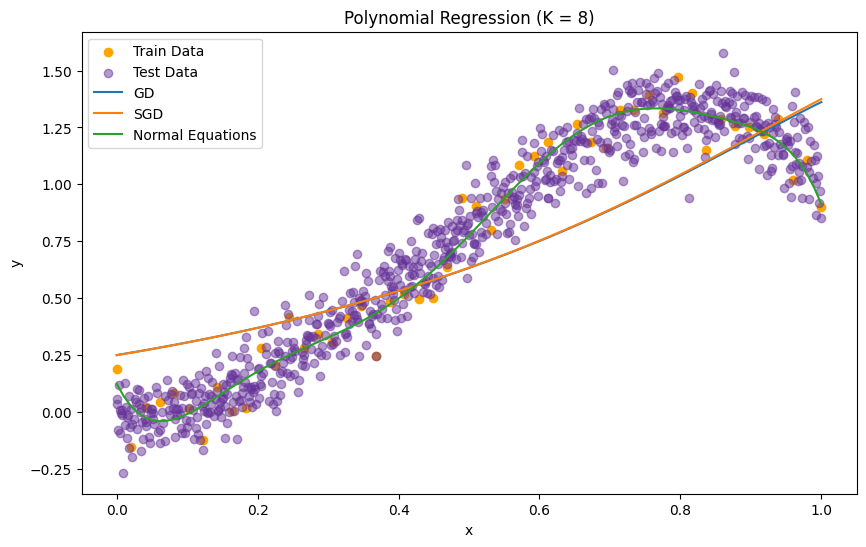

In [102]:

# MAP Experiments
print("MAP Performance:")
K = 8
X_train_poly = polynomial_features(X_train, K)
X_test_poly = polynomial_features(X_test, K)

lambdas = [0.1, 1, 10, 100]
for lam in lambdas:
    # Estimation methods
    theta_gd = gradient_descent(X_train_poly, Y_train, map_gradient, lam=0.1)
    theta_sgd = stochastic_gradient_descent(X_train_poly, Y_train, map_gradient, lam=0.1)
    theta_ne = normal_equations(X_train_poly, Y_train)

    # Compute errors
    gd_train_error = compute_error(X_train_poly, Y_train, theta_gd)
    sgd_train_error = compute_error(X_train_poly, Y_train, theta_sgd)
    ne_train_error = compute_error(X_train_poly, Y_train, theta_ne)

    gd_test_error = compute_error(X_test_poly, Y_test, theta_gd)
    sgd_test_error = compute_error(X_test_poly, Y_test, theta_sgd)
    ne_test_error = compute_error(X_test_poly, Y_test, theta_ne)

    print(f"λ = {lam}:")
    print(f"  GD   - Train Error: {gd_train_error:.4f}, Test Error: {gd_test_error:.4f}")
    print(f"  SGD  - Train Error: {sgd_train_error:.4f}, Test Error: {sgd_test_error:.4f}")
    print(f"  NE   - Train Error: {ne_train_error:.4f}, Test Error: {ne_test_error:.4f}")

    plot_regression(X_train, Y_train, X_test, Y_test, [theta_gd, theta_sgd, theta_ne], K, ['GD', 'SGD', 'Normal Equations'])
